## Amazon Music Reviews

##  Table of Contents:
* [Import data and modules](#first-bullet)
* [Data Cleaning](#second-bullet)
* [Data Exploration](#third-bullet)
* [Encoding](#third-bullet)
    * [One Hot Encoding](#section_3_1)
    * [Ordinal Encoding](#section_3_2)
* [Feature Selection](#fourth-bullet)
* [Model Training](#fifth-bullet)
* [Parameter Tuning](#sixth-bullet)
* [Testing and Discussuion](#seventh-bullet)

### Data and modules import <a class="anchor" id="first-bullet"></a>

A part of this project requires to do Natural Language Processing for Glove pre-trained word embeddings are used. These can be downloaded from the link below. The file with 100 features is used in order to minimize file size. However, more features can be used to increase accuracy of predictions as they capture more information about each word.

http://nlp.stanford.edu/data/glove.6B.zip

In [2]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import html
import unicodedata
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay,mean_squared_error

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import plot_confusion_matrix
 
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Conv1D, MaxPool1D,GlobalMaxPooling1D,Input, Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers.merge import Concatenate
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical,plot_model
from numpy import array
from numpy import asarray
from numpy import zeros

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nehel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nehel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nehel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
#Import and inspect the data
data_test = pd.read_csv("data/test.csv")
data_train = pd.read_csv("data/train.csv")
data_ratings = pd.read_csv("data/rating_pairs.csv")

In [5]:
data_train.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,5.0,"08 26, 2014",u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,1409011200,Jazz,$8.40,p23649501,3856620,NaN
1,5.0,"05 11, 2003",u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,1052611200,Alternative Rock,$10.98,p58458313,56086781,NaN
2,5.0,"12 5, 2017",u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,1512432000,Pop,$5.99,p97027626,55852154,NaN
3,5.0,"09 24, 2013",u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,1379980800,Jazz,$14.64,p43167086,43228100,NaN
4,5.0,"01 14, 2015",u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,1421193600,Alternative Rock,$9.92,p94494236,54425467,NaN


In [6]:
#From the data it can be seen that majority of the reviews are 5 star reviews
data_train['overall'].value_counts()

5.0    98213
4.0    29648
3.0    12154
2.0     5213
1.0     4772
Name: overall, dtype: int64

In [7]:
data_test.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,"02 11, 2017",u04140621,ok,Five Stars,1486771200,Pop,$31.20,p65721979,98944233,NaN
1,"01 29, 2018",u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,1517184000,Jazz,$34.04,p87809670,33903910,NaN
2,"08 29, 2005",u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,1125273600,Pop,$1.72,p52702240,35386470,NaN
3,"11 2, 2015",u35613516,Very good satch album,Four Stars,1446422400,Pop,$10.99,p01314374,12404766,NaN
4,"01 3, 2012",u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,1325548800,Alternative Rock,$7.98,p84396269,68253688,NaN


### Data Preperation and Cleaning <a class="anchor" id="second-bullet"></a>

Since majority of the data is textual, it may contain a lot of punctuations, stop words and tags which make it hard to process the data for machine learning. 

The following function performs cleaning on the data set and below are some of the operations conducted:

1. Convert data to lowercase
2. Remove tags
3. Remove stop-words
4. Remove punctuations
5. Remove only numerical data
6. Lemmetize the words



In [8]:
def clean_data(text):
    

    text = re.sub('@\S+', '', text) 
    text = text.replace('\n','')
    #change all text to lowercase
    text = text.lower()
    
    #delete all hyperlinks and URL's
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #Convert all HTML to ASCII
    text = html.unescape(text)
    
    #Remove all tags
    text = text.translate(str.maketrans('','','/<[^>]+>/'))
    
    #Remove all stop-words
    text = (" ").join([w for w in word_tokenize(text) if not w in stop_words])
    
    #Remove the word 'rt'
    text = re.sub('rt ', '', text)
    
    #Remove all punctuations
    text = re.sub('[^A-Za-z0-9]', ' ', text)
    
    #Remove all only numerical data
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
    
    #For generic dataset, remove twitter handle
    
    lem=WordNetLemmatizer()
    
    words_lem = [lem.lemmatize(word) for word in word_tokenize(text)]
    words_lem = [word for word in words_lem if (len(word)>1)]
    
    text = (" ").join(words_lem)
    
    return str(text)

Since the reviewText and Summary columns both contain textual data, these can be combined before clearning.

In [9]:
#Combine review and summary text
data_train['reviewText'] = data_train['reviewText'] + ' ' + data_train['summary']
data_test['reviewText']= data_test['reviewText'] + ' ' + data_test['summary']

In [10]:
#Clean train dataset
data_train['reviewText'] = data_train['reviewText'].map(str)
data_train.drop(['reviewTime','unixReviewTime','reviewHash'],axis=1,inplace=True)
data_train['reviewText'] = data_train['reviewText'].apply(lambda x: clean_data(x))

#Clean test dataset
data_test['reviewText'] = data_test['reviewText'].map(str)
data_test.drop(['reviewTime','unixReviewTime','reviewHash'],axis=1,inplace=True)
data_test['reviewText'] = data_test['reviewText'].apply(lambda x: clean_data(x))

In order to use the price data in our analysis, it needs to be cleaned by converting into float values and then any missing values have to be imputed by the median.

In [11]:
#The below function identifies data that has pricing and removes $, otherwise it make it as nan
def get_price(text):
    if len(text) < 10:
        text = text.replace("$","")
    else:
        text = np.nan
    return text

In [12]:
data_train['price'] = data_train['price'].apply(lambda x: get_price(x))
data_train['price'] = data_train['price'].astype(float)
data_train['price'] = data_train['price'].fillna(data_train['price'].median())

data_test['price'] = data_test['price'].apply(lambda x: get_price(x))
data_test['price'] = data_test['price'].astype(float)
data_test['price'] = data_test['price'].fillna(data_test['price'].median())

price = data_train['price'].values
price_submit = data_test['price'].values

In [13]:
#In order to use price in training a model, it is scaled using MinMaxScaler
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(price.reshape(-1,1))

### Data Exploration <a class="anchor" id="third-bullet"></a>

In [14]:
import plotly.graph_objects as go
import plotly.express as px
sns.set_theme(style='darkgrid')

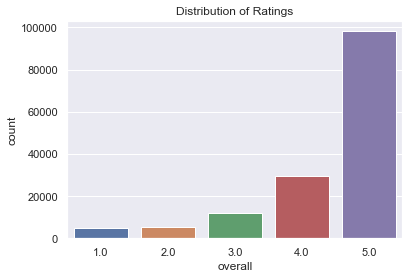

In [15]:
#Lets look at how the review ratings are distributed
sns.countplot(data_train.overall).set_title('Distribution of Ratings')
plt.savefig("images\Distribution_of_ratings.png",bbox_inches='tight')

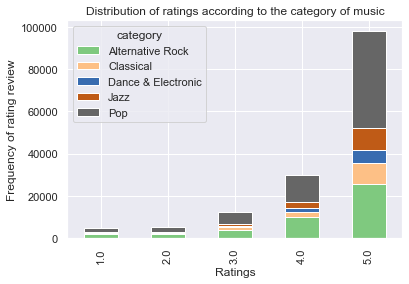

In [16]:
t_df = data_train.copy()
t_df['ct'] = 1
t_df = pd.pivot_table(t_df, values = 'ct', index='overall', columns='category', aggfunc = np.sum, fill_value=0)
ax = t_df.plot.bar(stacked=True, colormap='Accent')
ax.set_title('Distribution of ratings according to the category of music')
ax.set_xlabel('Ratings')
ax.set_ylabel('Frequency of rating review')
plt.savefig("images\Distribution_of_ratings_category.png",bbox_inches='tight')

In [16]:
#Looking at the reviewed items, there are a total of about 25,000 items that have been reviewed.
#The most number of reviews are 222 and the least are 1
UniqueItems = data_train.itemID.value_counts()

In [17]:
UniqueUsers = data_train.reviewerID.value_counts()

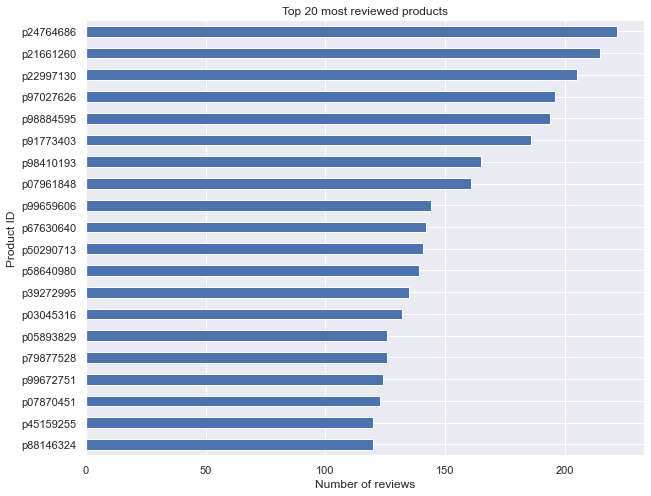

In [18]:
fig = plt.figure(figsize=(10,8))
UniqueItems[::-1][-20:].plot(kind='barh')
plt.xlabel("Number of reviews")
plt.ylabel("Product ID")
plt.title("Top 20 most reviewed products")
plt.savefig("images\Top_reviewed.png")

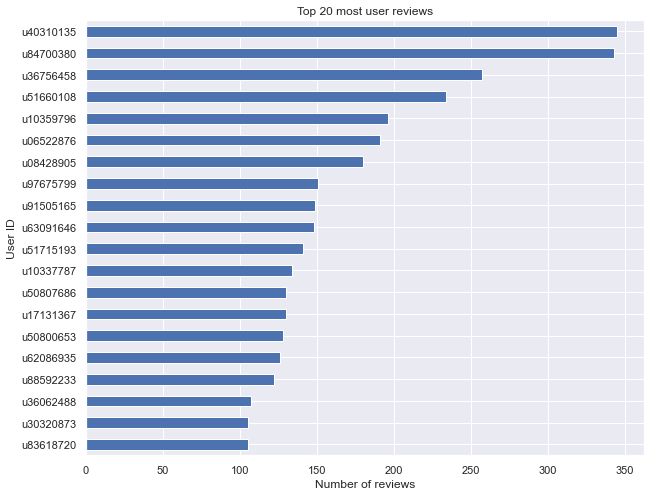

In [19]:
fig = plt.figure(figsize=(10,8))
UniqueUsers[::-1][-20:].plot(kind='barh')
plt.xlabel("Number of reviews")
plt.ylabel("User ID")
plt.title("Top 20 most user reviews")
plt.savefig("images\Top_reviewers.png")

In [20]:
data_train['sentiment'] = data_train['overall'].apply(lambda x: "negative" if x <3 else "positive")

In [21]:
#Top 20 products review sentiments
df_reviews = data_train.groupby(['itemID','sentiment']).count()['summary'].unstack(fill_value=0)

In [22]:
df_reviews = df_reviews.loc[UniqueItems[::-1][-20:].index]

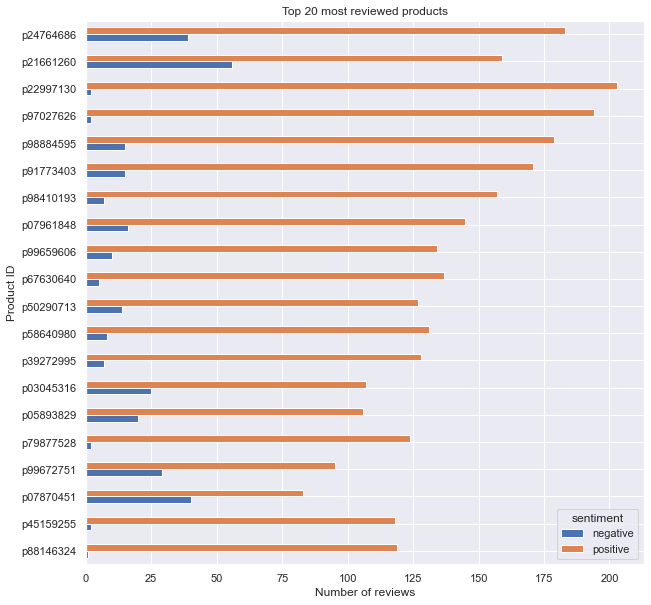

In [23]:
df_reviews.plot.barh(figsize =(10,10))
plt.xlabel("Number of reviews")
plt.ylabel("Product ID")
plt.title("Top 20 most reviewed products")
plt.savefig("images\Top_reviewed_sentiments.png")

Wordclouds are a great way to visualize which words are being used most commonly. Below are the wordclouds for different sentiments.

In [24]:
data_train

,overall,reviewerID,reviewText,summary,category,price,itemID,image,sentiment
0,5.0,u92990698,contemporary jazz soul performer made two deca...,""" CLASSIQUE """,Jazz,8.40,p23649501,NaN,positive
1,5.0,u36200649,good idea put pop orchestral music matrix relo...,Exceeded my Expectations - This album RAWKS!,Alternative Rock,10.98,p58458313,NaN,positive
2,5.0,u10721702,great collection carole king song must have ca...,A Must-have for Carole King Fans,Pop,5.99,p97027626,NaN,positive
3,5.0,u86003775,album brilliant piece jazz fusion stafinish pe...,A Master piece!,Jazz,14.64,p43167086,NaN,positive
4,5.0,u25672859,waited long time dvd released watchingyear old...,especially if you like concert videos,Alternative Rock,9.92,p94494236,NaN,positive
...,...,...,...,...,...,...,...,...,...
149995,5.0,u29136602,something wesley voice make swoon little bit v...,Just right.,Alternative Rock,9.49,p26326919,NaN,positive
149996,5.0,u51715193,many recording verdi requiem often asked quest...,Being there in vibrant immediacy of performan...,Classical,14.83,p69247882,NaN,positive
149997,5.0,u28696060,best overall album revisionist fall out follow...,Creative rebirth and possibly....,Alternative Rock,18.86,p07028930,NaN,positive
149998,5.0,u04925906,believe upon time artist like enchantment coul...,Once Upon A Time,Pop,19.99,p38606785,NaN,positive


In [25]:
positive_ratings = data_train[data_train['sentiment'] == "positive"]
negative_ratings = data_train[data_train['sentiment'] == "negative"]

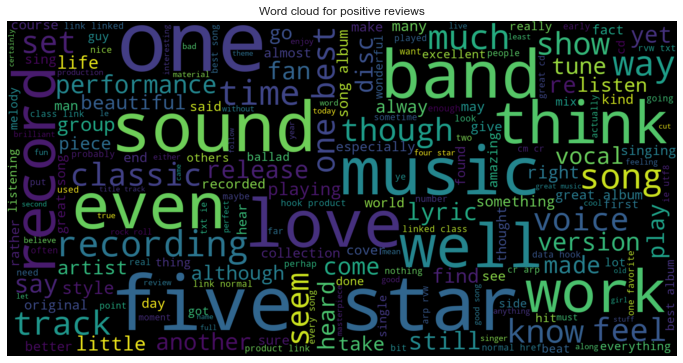

In [26]:
positive_ratings = positive_ratings['reviewText']
positive_ratings_Str = []
for t in positive_ratings:
    positive_ratings_Str.append(t)
positive_ratings_Str = pd.Series(positive_ratings_Str).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(positive_ratings_Str)
fig, axes = plt.subplots(1, 1, figsize = (12,10))
axes.set_title('Word cloud for positive reviews')
axes.imshow(wordcloud, interpolation="bilinear")
axes.axis("off")
plt.savefig("images\positive_wordcloud.png")

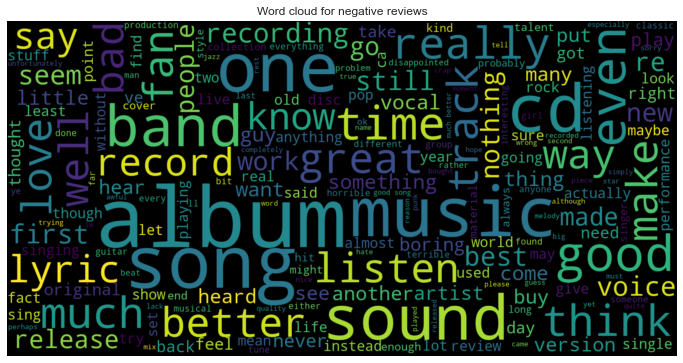

In [27]:
negative_ratings = negative_ratings['reviewText']
negative_ratings_Str = []
for t in negative_ratings:
    negative_ratings_Str.append(t)
negative_ratings_Str = pd.Series(negative_ratings_Str).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(negative_ratings_Str)
fig, axes = plt.subplots(1, 1, figsize = (12,10))
axes.set_title('Word cloud for negative reviews')
axes.imshow(wordcloud, interpolation="bilinear")
axes.axis("off")
plt.savefig("images/Negative_wordcloud.png")

### Model Preparation <a class="anchor" id="fourth-bullet"></a>



In order to predict the rating of a prodcut by a user we will be trainig Logistic Regression and Multinomial Navie Bayes models.

To convert the text data into vectors, Tf-idf will be used.

In [28]:
#Vectorize data for training
tfidf = TfidfVectorizer(max_features = 1500)
X_tfidf = tfidf.fit_transform(data_train['reviewText']).toarray()

In [29]:
#split data into test and train
y = data_train['overall'].values
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf,y, test_size = 0.2, random_state=42)

#### Logistic Regression <a class="anchor" id="fourth_one-bullet"></a>

In [16]:
# grid={"C":[0.1, 1, 10], "penalty":["l1","l2"],"solver":['liblinear', 'saga']}
# model = LogisticRegression()

# model_cv = GridSearchCV(model,grid,cv=5)

# model_cv.fit(X_train_tfidf,y_train_tfidf)

In [17]:
# print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
# print("accuracy :",model_cv.best_score_)

In [30]:
model = LogisticRegression(C=1,penalty='l1',solver='saga')
model.fit(X_train_tfidf,y_train_tfidf)
train_pred = model.predict(X_train_tfidf)
y_pred = model.predict(X_test_tfidf)

In [32]:
CM

array([[  408,    90,    68,    38,   328],
       [  122,   194,   240,   159,   364],
       [   63,    86,   797,   558,   870],
       [   35,    25,   324,  2112,  3468],
       [   83,    24,   160,  1012, 18372]], dtype=int64)

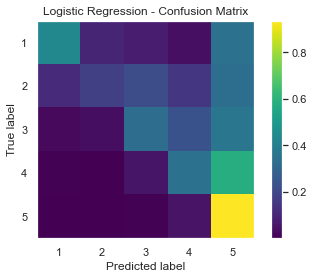

In [44]:
plot_confusion_matrix(model, X_test_tfidf, y_test_tfidf,display_labels=[1, 2, 3, 4, 5], normalize="true",include_values=False)
plt.grid(None)
plt.title("Logistic Regression - Confusion Matrix")
plt.savefig("images/logistic_regression_matrix.png")

In [ ]:
print(classification_report(y_test_tfidf, y_pred, labels=[1, 2, 3, 4, 5]))

              precision    recall  f1-score   support

           1       0.58      0.44      0.50       932
           2       0.45      0.18      0.25      1079
           3       0.50      0.34      0.40      2374
           4       0.55      0.35      0.43      5964
           5       0.79      0.94      0.85     19651

    accuracy                           0.73     30000
   macro avg       0.57      0.45      0.49     30000
weighted avg       0.70      0.73      0.70     30000



In [ ]:
training_acc = accuracy_score(y_train_tfidf, train_pred)*100
testing_acc = accuracy_score(y_test_tfidf, y_pred)*100   
mse = mean_squared_error(y_test_tfidf, y_pred)
mse_train = mean_squared_error(y_train_tfidf, train_pred)
print("Training accuracy: " +str(round(training_acc,3))+"%")
print("Test accuracy: " +str(round(testing_acc,3))+"%")
print("MSE Train: ", mse_train)
print("MSE: ", mse)

Training accuracy: 74.08%
Test accuracy: 72.953%
MSE Train:  0.6995083333333333
MSE:  0.7325


#### Multinomial Naive Bayes <a class="anchor" id="fourth_two-bullet"></a>

In [ ]:
grid={'alpha':[0.01,0.1,1,10,100]}
gnb = MultinomialNB()
gnb_cv = GridSearchCV(gnb,grid,cv=10)
gnb_cv.fit(X_train_tfidf,y_train_tfidf)

In [ ]:
print("tuned hpyerparameters :(best parameters) ",gnb_cv.best_params_)
print("accuracy :",gnb_cv.best_score_)

In [ ]:
gnb = MultinomialNB(alpha=0.01)
gnb.fit(X_train_tfidf,y_train_tfidf)
train_pred = gnb.predict(X_train_tfidf)
y_pred = gnb.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test_tfidf, y_pred, labels=[1, 2, 3, 4, 5]))

              precision    recall  f1-score   support

           1       0.80      0.10      0.18       932
           2       0.75      0.01      0.01      1079
           3       0.66      0.03      0.07      2374
           4       0.58      0.13      0.21      5964
           5       0.68      0.99      0.81     19651

    accuracy                           0.68     30000
   macro avg       0.69      0.25      0.25     30000
weighted avg       0.67      0.68      0.58     30000



In [ ]:
training_acc = accuracy_score(y_train_tfidf, train_pred)*100
testing_acc = accuracy_score(y_test_tfidf, y_pred)*100   
mse = mean_squared_error(y_test_tfidf, y_pred)

print("Training accuracy: " +str(round(training_acc,3))+"%")
print("Test accuracy: " +str(round(testing_acc,3))+"%")
print("MSE: ", mse)

Training accuracy: 67.918%
Test accuracy: 67.95%
MSE:  1.2005333333333332


#### LSTM - Neural Networks Model <a class="anchor" id="fourth_three-bullet"></a>

To train the NN model, the text data will be vectorized using word embeddings. 

The LSTM model will be trained on the following features:
1. Review Text
2. Price
3. Category

Below we will be doing feature prepartion to get the model up and running.

In [46]:
#Split data used for NLP using LSTM and word embeddings
y = data_train['overall'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_train['reviewText'], y, test_size=0.20, random_state=42)

In [47]:
#One hot encode categories
genres = data_train['category']
genres_features = pd.get_dummies(genres).values
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(genres_features, y, test_size=0.20, random_state=42)

In [48]:
#Use scaled price data
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(price_scaled, y, test_size=0.20, random_state=42)

In [49]:
#Word tokenizer from Keras is used to one hot encode words in a review
#It assigns an index to different words that can be used to then vectorize it using word embeddings
#The tokenizer looks at all the text data and keeps the most frequent 6000 words however all the words are stored in the vocabolary

tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train2)

X_train = tokenizer.texts_to_sequences(X_train2)
X_test = tokenizer.texts_to_sequences(X_test2)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

In [50]:
#Creates an embedding dictionary using the glove word embedding 
#Then loops through each word and vectorizes based on 100 features, these features have values which help determine how similar words are
embeddings_dictionary = dict()

glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#Create model function to be used in GridSearchCV
#Only run if GridSearchCV is required

def create_model(learning_rate = 0.01, activation = 'relu'):
  deep_inputs = Input(shape=(maxlen,))
  genre_inputs = Input(shape=(5,))
  price_inputs = Input(shape=(1,))

  # the first branch operates on the first input
  x = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=True)(deep_inputs)
  x = LSTM(36)(x)
  x = Model(inputs=deep_inputs, outputs=x)

  # the second branch opreates on the second input
  y = Dense(16, activation ="relu")(price_inputs)
  y = Dropout(0.5)(y)
  y = Model(inputs=price_inputs, outputs=y)

  # the third branch opreates on the third input
  z = Dense(16, activation ="relu")(genre_inputs)
  z = Dropout(0.5)(z)
  z = Model(inputs=genre_inputs, outputs=z)

  # combine the output of the two branches
  combined = concatenate([x.output, y.output,z.output])

  output_layer = Dense(1, activation='relu')(combined)

  model = Model(inputs=[x.input, y.input,z.input], outputs=output_layer)
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model

In [ ]:
seed = 7
np.random.seed(seed)
model = KerasRegressor(build_fn=create_model, verbose=1)
batch_size = [64, 128]
epochs = [10, 20]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(x=[X_train,X_train_price,X_train_genre], y= y_train2)

In [52]:
#Fit model again given best parameters
deep_inputs = Input(shape=(maxlen,))
genre_inputs = Input(shape=(5,))
price_inputs = Input(shape=(1,))

# the first branch operates on the first input
x = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
#x = Conv1D(filters=16,kernel_size=3,padding='same',activation='relu')(x)
#x = MaxPool1D(pool_size=2)(x)
x = LSTM(128)(x)
x = Model(inputs=deep_inputs, outputs=x)

# the second branch opreates on the second input
y = Dense(64, activation ="relu")(price_inputs)
y = Dropout(0.5)(y)
y = Model(inputs=price_inputs, outputs=y)

# the third branch opreates on the third input
z = Dense(64, activation ="relu")(genre_inputs)
z = Dropout(0.5)(z)
z = Model(inputs=genre_inputs, outputs=z)

# combine the output of the two branches
combined = concatenate([x.output, y.output,z.output])

output_layer = Dense(1, activation='linear')(combined)

model = Model(inputs=[x.input, y.input,z.input], outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(x = [X_train,X_train_price,X_train_genre],y= y_train2, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 16s 20ms/step - loss: 1.7972 - mse: 1.7972 - val_loss: 0.6620 - val_mse: 0.6620
Epoch 2/10
750/750 [==============================] - 15s 19ms/step - loss: 0.6168 - mse: 0.6168 - val_loss: 0.6004 - val_mse: 0.6004
Epoch 3/10
750/750 [==============================] - 14s 19ms/step - loss: 0.5616 - mse: 0.5616 - val_loss: 0.5620 - val_mse: 0.5620
Epoch 4/10
750/750 [==============================] - 14s 19ms/step - loss: 0.5275 - mse: 0.5275 - val_loss: 0.5537 - val_mse: 0.5537
Epoch 5/10
750/750 [==============================] - 14s 19ms/step - loss: 0.5065 - mse: 0.5065 - val_loss: 0.5345 - val_mse: 0.5345
Epoch 6/10
750/750 [==============================] - 14s 19ms/step - loss: 0.4870 - mse: 0.4870 - val_loss: 0.5264 - val_mse: 0.5264
Epoch 7/10
750/750 [==============================] - 14s 19ms/step - loss: 0.4756 - mse: 0.4756 - val_loss: 0.5197 - val_mse: 0.5197
Epoch 8/10
750/750 [==============================] - 15s 19ms

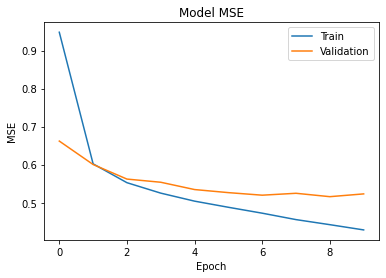

In [63]:
#Summarize history of mse for the model training
plt.plot(history.history['mse'],label="Train")
plt.plot(history.history['val_mse'],label="Validation")
plt.title("Model MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()

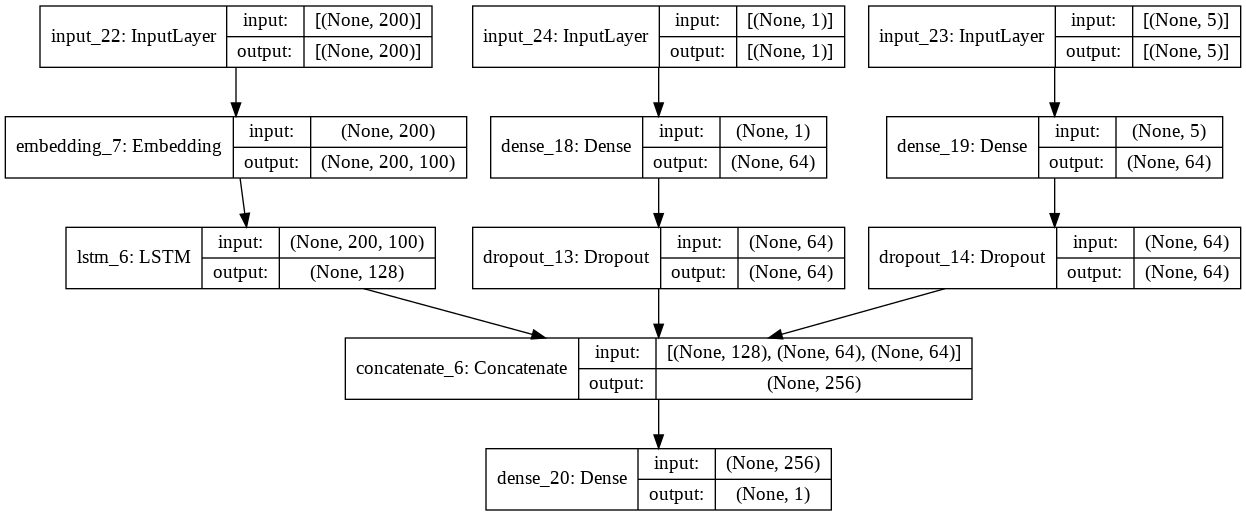

In [65]:
#Plot NN model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [61]:
#Make predictions on test and train data
y_pred_train = model.predict([X_train,X_train_price,X_train_genre])
y_pred_test = model.predict([X_test,X_test_price,X_test_genre])

In [67]:
#Since a regression model is used, some predictions will be greater than 5 and some less than 1
#This is cleaned up below
for i,n in enumerate(y_pred_train):
  if n < 1:
    y_pred_train[i] = 1
  if n >5:
    y_pred_train[i] = 5

for i,n in enumerate(y_pred_test):
  if n < 1:
    y_pred_test[i] = 1
  if n >5:
    y_pred_test[i] = 5

In [68]:
#Look at Rmse to check for overfitting
mse = mean_squared_error(y_test2, y_pred_test)
mse_train = mean_squared_error(y_train2, y_pred_train)
print("MSE Train: ", mse_train)
print("MSE Test: ", mse)

MSE Train:  0.4260529166225169
MSE Test:  0.49867166309815825


#### Make predictions on test data <a class="anchor" id="fourth_three-bullet"></a>

In [70]:
#import test review data and tokenize
X_test_data = data_test['reviewText']

X_test = tokenizer.texts_to_sequences(X_test_data)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

In [71]:
#Standardize price information for test data
price_submit = scaler.transform(price_submit.reshape(-1,1))

In [72]:
#One hot encode genres data
genres_submit = pd.get_dummies(data_test['category']).values

In [73]:
#make prediction on test data
y_pred_submit = model.predict([X_test,price_submit,genres_submit])

In [76]:
#Since predictions are regressions, fix values greater and 5 and less than 1
for i,n in enumerate(y_pred_submit):
  if n < 1:
    y_pred_submit[i] = 1
  if n >5:
    y_pred_submit[i] = 5

In [77]:
y_pred_submit = np.concatenate(y_pred_submit, axis=0 )

In [79]:
#Prepare output file
y_pred_submit = y_pred_submit.tolist()
output_file = data_ratings.copy()
output_file['prediction'] = y_pred_submit
output_file.to_csv(r'OutputFile_April_3.csv', index = False, header=True)

In [83]:
output_file = output_file.round({'prediction':0})

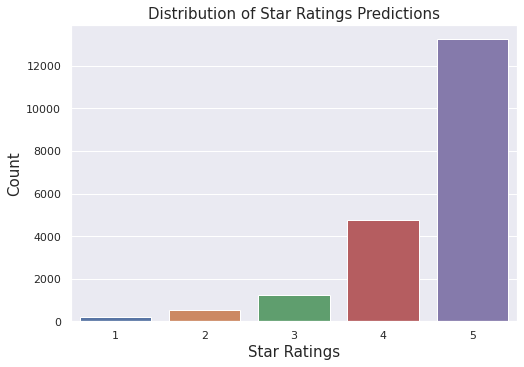

In [86]:
#Visualize Predictions based on rounded data
pp = plt.figure(figsize=(8,12))
ax1 = pp.add_subplot(2,1,1) 
sns.set_theme(style='darkgrid')
sns.countplot(data = output_file, x = 'prediction', ax = ax1, order=[1,2,3,4,5])
plt.title("Distribution of Star Ratings Predictions", fontsize=15)
plt.xlabel("Star Ratings", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()